### By Eu Jin Lee 

## Problem Statement

As a data scientist with the National Suicide Prevention Lifeline, we have been monitoring the posts on  SuicideWatch subreddit for suggestive intent of suicide among Redditors. This is in hopes that we may be able to intervene quickly and provide support. 

However, we came across a problem when the reddit 

## Executive Summary

## Contents 

- [Data Dictionary](#Data-Dictionary)
- [Import Packages](#Import-Packages)
- [Collecting Reddit Posts and Building Dataframe](#Collecting-Reddit-Posts-and-Building-Dataframe)
- [Model Preparation](#Model-Preparation)
- [Modeling](#Modeling)
- [Model Selection](#Model-Selection)
- [Model Evaluation](#Model-Evaluation)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)
- [Reference](#Reference)

## Data Dictionary

## Import Packages 

In [1]:
#Standard Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Web Request Package
import requests

#Modeling Packages 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression

#Misc Packages
import datetime as dt
import time

pd.set_option('display.max_columns', 100)

## Collecting Reddit Posts and Building Dataframe

In [8]:
# here's an example query url
url = "https://api.pushshift.io/reddit/search/submission?subreddit=suicidewatch"

In [9]:
res = requests.get(url)

In [10]:
# Explicitly get the status code
res.status_code

200

In [13]:
# Convert the string to JSON, or dictionary, format
json_data = res.json()

In [74]:
posts = pd.DataFrame(json_data['data'])

In [16]:
# let's filter only the main columns of data
subfields = ['id','title', 'selftext', 'subreddit', 'created_utc', 'author','score']
posts[subfields].head()

,id,title,selftext,subreddit,created_utc,author,num_comments,score
0,htkbmg,How do I say goodbye to family before offing m...,,SuicideWatch,1595092931,xAndreaNadia,2,1
1,htk9w1,How do I move forward?,[deleted],SuicideWatch,1595092757,[deleted],4,3
2,htk7ni,This crippling loneliness is too much,I haven't left my house or talked to anyone in...,SuicideWatch,1595092531,throwme-away2048,5,2
3,htk5cx,My husband scares me,The past couple of days my husband has been so...,SuicideWatch,1595092304,_hikes,6,8
4,htk4wm,Veteran with exhausted options,I'm a disabled veteran with complex PTSD. I've...,SuicideWatch,1595092259,george_amberson19,1,3


In [86]:
#Creates the initial dataframe 
#1000 most recent comments at present time (1595206333)
url = "https://api.pushshift.io/reddit/search/submission?subreddit=suicidewatch&before=1595206333&sort=des&size=1000"
headers = {'User-agent': 'ejlee'}
res = requests.get(url)
json = res.json()
postssw = pd.DataFrame(json['data'])

postssw = postssw[['id','title','selftext','subreddit','created_utc','author','score']]
#Filters for deleted posts
postssw = postssw[postssw['selftext']!='[deleted]']
postssw = postssw[postssw['selftext'] != '[removed]']
postssw = postssw[postssw['author'] != '[deleted]']

#Loops backward over 12 day intervals, adding the 1000 most recent comments prior to each timepoint
for i in range(1,80):
    url = "https://api.pushshift.io/reddit/search/submission?subreddit=suicidewatch&before={}&sort=des&size=1000".format(1595206333 - i*1036800)
    headers = {'User-agent': 'ejlee'}
    print(url)
    res = requests.get(url)
    json = res.json()
    postbloc = pd.DataFrame(json['data'])
    postbloc = postbloc[['id','title','selftext','subreddit','created_utc','author','score']]
    postbloc = postbloc[postbloc['selftext']!='[deleted]']
    postbloc = postbloc[postbloc['selftext'] != '[removed]']
    postbloc = postbloc[postbloc['author'] != '[deleted]']
    postssw = pd.concat([postssw, postbloc], ignore_index=True)
    time.sleep(1)

https://api.pushshift.io/reddit/search/submission?subreddit=suicidewatch&before=1594169533&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=suicidewatch&before=1593132733&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=suicidewatch&before=1592095933&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=suicidewatch&before=1591059133&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=suicidewatch&before=1590022333&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=suicidewatch&before=1588985533&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=suicidewatch&before=1587948733&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=suicidewatch&before=1586911933&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=suicidewatch&before=1585875133&sort=des&size=1000
https://ap

https://api.pushshift.io/reddit/search/submission?subreddit=suicidewatch&before=1516409533&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=suicidewatch&before=1515372733&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=suicidewatch&before=1514335933&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=suicidewatch&before=1513299133&sort=des&size=1000


In [88]:
len(postssw)

7346

In [90]:
#Creates the initial dataframe 
#1000 most recent comments at present time (1595206333)
url = "https://api.pushshift.io/reddit/search/submission?subreddit=offmychest&before=1595206333&sort=des&size=1000"
headers = {'User-agent': 'ejlee'}
res = requests.get(url)
json = res.json()
postsomc = pd.DataFrame(json['data'])

postsomc = postsomc[['id','title','selftext','subreddit','created_utc','author','score']]
#Filters for deleted posts
postsomc = postsomc[postsomc['selftext']!='[deleted]']
postsomc = postsomc[postsomc['selftext'] != '[removed]']
postsomc = postsomc[postsomc['author'] != '[deleted]']

#Loops backward over 12 day intervals, adding the 1000 most recent comments prior to each timepoint
for i in range(1,80):
    url = "https://api.pushshift.io/reddit/search/submission?subreddit=offmychest&before={}&sort=des&size=1000".format(1595206333 - i*1036800)
    headers = {'User-agent': 'ejlee'}
    res = requests.get(url)
    print(url)
    json = res.json()
    postbloc = pd.DataFrame(json['data'])
    postbloc = postbloc[['id','title','selftext','subreddit','created_utc','author','score']]
    postbloc = postbloc[postbloc['selftext']!='[deleted]']
    postbloc = postbloc[postbloc['selftext'] != '[removed]']
    postbloc = postbloc[postbloc['author'] != '[deleted]']
    postsomc = pd.concat([postsomc, postbloc], ignore_index=True)
    time.sleep(1)

https://api.pushshift.io/reddit/search/submission?subreddit=offmychest&before=1594169533&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=offmychest&before=1593132733&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=offmychest&before=1592095933&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=offmychest&before=1591059133&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=offmychest&before=1590022333&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=offmychest&before=1588985533&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=offmychest&before=1587948733&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=offmychest&before=1586911933&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=offmychest&before=1585875133&sort=des&size=1000
https://api.pushshift.io/red

https://api.pushshift.io/reddit/search/submission?subreddit=offmychest&before=1515372733&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=offmychest&before=1514335933&sort=des&size=1000
https://api.pushshift.io/reddit/search/submission?subreddit=offmychest&before=1513299133&sort=des&size=1000


In [91]:
len(postsomc)

6792

In [92]:
posts = pd.concat([postssw, postsomc])
posts = posts.reset_index(drop=True)
posts.head()

,id,title,selftext,subreddit,created_utc,author,score
0,hu7tt6,what went wrong,www\n\nI ask myself this question all the time...,SuicideWatch,1595191663,fuckdatshitaye,1
1,hu7r5n,How old to buy rope,Does anyone know if there’s an age restriction...,SuicideWatch,1595191408,roobs16,1
2,hu7qrx,What’s the point of living if I cannot even ge...,"Serious question. I was born catholic, but few...",SuicideWatch,1595191377,Oxidus999,3
3,hu7m4c,My Grandpa died and I wish I could trade place...,He was a great guy and everyone seemed to love...,SuicideWatch,1595190916,furfoxandyling,3
4,hu7lj9,No one loves me,Literally blood dripping from my wrist right n...,SuicideWatch,1595190857,BrokenAndDestroyed,1


In [93]:
posts.shape

(14138, 7)

In [94]:
#Import Regex
import re

#This function selects any consecutive combination of \r's and \n's in a bloc of text, 
#and replaces that selection with a single space.
def replace_linebreaks_w_space(x):
    return re.sub('([\r\n]+)',' ',x)

#This function selects any stretch of two or more consecutive spaces in a bloc of text,
#and replaces that selection with a single space.
def replace_multispace_w_space(x):
    return re.sub('([ ]{2,})',' ',x)

#Here we take every comment and apply the two functions to it.
posts['selftext'] = posts['selftext'].map(replace_linebreaks_w_space)
posts['selftext'] = posts['selftext'].map(replace_multispace_w_space)

In [95]:
#Strip away any spaces at the beginning or end of each comment, splits the comment into a list of words, 
#and returns the length of that list (i.e.; the number of words in the comment)
posts['word_length'] = posts['selftext'].map(lambda x: len(x.strip().split(' ')))

In [96]:
posts.head()

,id,title,selftext,subreddit,created_utc,author,score,word_length
0,hu7tt6,what went wrong,www I ask myself this question all the time be...,SuicideWatch,1595191663,fuckdatshitaye,1,57
1,hu7r5n,How old to buy rope,Does anyone know if there’s an age restriction...,SuicideWatch,1595191408,roobs16,1,29
2,hu7qrx,What’s the point of living if I cannot even ge...,"Serious question. I was born catholic, but few...",SuicideWatch,1595191377,Oxidus999,3,203
3,hu7m4c,My Grandpa died and I wish I could trade place...,He was a great guy and everyone seemed to love...,SuicideWatch,1595190916,furfoxandyling,3,52
4,hu7lj9,No one loves me,Literally blood dripping from my wrist right n...,SuicideWatch,1595190857,BrokenAndDestroyed,1,42


In [97]:
posts['subreddit'].value_counts()

SuicideWatch    7346
offmychest      6792
Name: subreddit, dtype: int64

In [98]:
posts.to_csv('posts_final.csv',index=False)

## Building Classification Model for Reddit Post

### Instantiating feature and target variables

In [102]:
#Separate data into comment text (features) and subreddit (target variable)
X = posts['selftext']
y = posts['subreddit']

#Train test split. Stratify=y guarantees that class balance will be maintained across train and test bloc
X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=True,stratify=y)

### Building a CountVectorizer, Logistic Regression Pipeline

In [103]:
#Creates pipeline to handle vectorization and logistic regression steps
pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('model', LogisticRegression())
     ])

#Specifies different hyperparameter values that we want to test across
params = {
    'vect__ngram_range':[(1,3)],
    'vect__min_df':[2,5],
    'vect__stop_words':[None,'english'],
    'model__penalty':['l2','l1'],
    'model__C':[0.1, 1, 10],
}

#Executes GridSearch
gs_lr1 = GridSearchCV(pipe, params, cv=4, verbose=3, n_jobs=-1)
gs_lr1.fit(X_train, y_train)

Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  4.8min finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 1, 10],
                         'model__penalty': ['l2', 'l1'], 'vect__min_df': [2, 5],
                         'vect__ngram_range': [(1, 3)],
                         'vect__stop_words': [None, 'english']},
             verbose=3)

In [104]:
#Training data accuracy score
gs_lr1.score(X_train, y_train)

0.978968216542488

In [105]:
#Test data accuracy score
gs_lr1.score(X_test, y_test)

0.8333804809052334

In [106]:
#Shows us which hyperparameters were chosen
gs_lr1.best_estimator_.steps

[('vect', CountVectorizer(min_df=5, ngram_range=(1, 3))),
 ('model', LogisticRegression(C=0.1))]

### Building a TFIDFVectorizer, Logistic Regression Pipeline

In [107]:
pipe2 = Pipeline([
    ('vect', TfidfVectorizer()),
    ('model', LogisticRegression())
     ])

params = {
    'vect__ngram_range':[(1,3)],
    'vect__min_df':[2,5],
    'vect__stop_words':[None,'english'],
    'model__penalty':['l2','l1'],
    'model__C':[0.1, 1, 10],
}

gs_lr2 = GridSearchCV(pipe2, params, cv=4, verbose=2, n_jobs=-1)
gs_lr2.fit(X_train, y_train)

Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  4.1min finished


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 1, 10],
                         'model__penalty': ['l2', 'l1'], 'vect__min_df': [2, 5],
                         'vect__ngram_range': [(1, 3)],
                         'vect__stop_words': [None, 'english']},
             verbose=2)

In [108]:
#Training data score
gs_lr2.score(X_train, y_train)

0.9941525983212298

In [109]:
#Test data score
gs_lr2.score(X_test, y_test)

0.8427157001414427

In [110]:
#Shows which hyperparameters were chosen
gs_lr2.best_estimator_.steps

[('vect', TfidfVectorizer(min_df=2, ngram_range=(1, 3))),
 ('model', LogisticRegression(C=10))]

In [111]:
def fancy_confusion_matrix(y_test, preds):

    cmat = confusion_matrix(y_test, preds)
    print(f'Accuracy: {accuracy_score(y_test, preds)}')
    print(classification_report(y_test, preds))
    return pd.DataFrame(cmat, columns=['Predicted ' + str(i) for i in ['SuicideWatch','OffMyChest']],\
            index=['Actual ' + str(i) for i in ['SuicideWatch','OffMyChest']])

predicts = gs_lr2.predict(X_test)
fancy_confusion_matrix(y_test, predicts)

Accuracy: 0.8427157001414427
              precision    recall  f1-score   support

SuicideWatch       0.83      0.87      0.85      1837
  offmychest       0.85      0.81      0.83      1698

    accuracy                           0.84      3535
   macro avg       0.84      0.84      0.84      3535
weighted avg       0.84      0.84      0.84      3535



,Predicted SuicideWatch,Predicted OffMyChest
Actual SuicideWatch,1599,238
Actual OffMyChest,318,1380


In [113]:
coefs = pd.DataFrame(gs_lr2.best_estimator_.steps[1][1].coef_).T
coefs.columns = ['coef']
coefs['ngram'] = gs_lr2.best_estimator_.steps[0][1].get_feature_names()
coefs = coefs[['ngram','coef']]
coefs = coefs.sort_values('coef')
coefs.to_csv('data/coef_ranks.csv',index=False)

In [114]:
coefs.head(15)

,ngram,coef
297802,suicide,-15.548708
297635,suicidal,-12.104862
177090,kill,-10.608897
81423,die,-8.767290
92766,end,-7.814621
177142,kill myself,-7.745955
183272,life,-7.208831
334801,to die,-6.944135
374472,will,-6.445749
335371,to end,-6.199023


In [115]:
len(coefs)

389888

In [117]:
from wordcloud import WordCloud

SWWordCloud = coefs[0:200]
OMCWordCloud = coefs.sort_values('coef',ascending=False)[0:200]

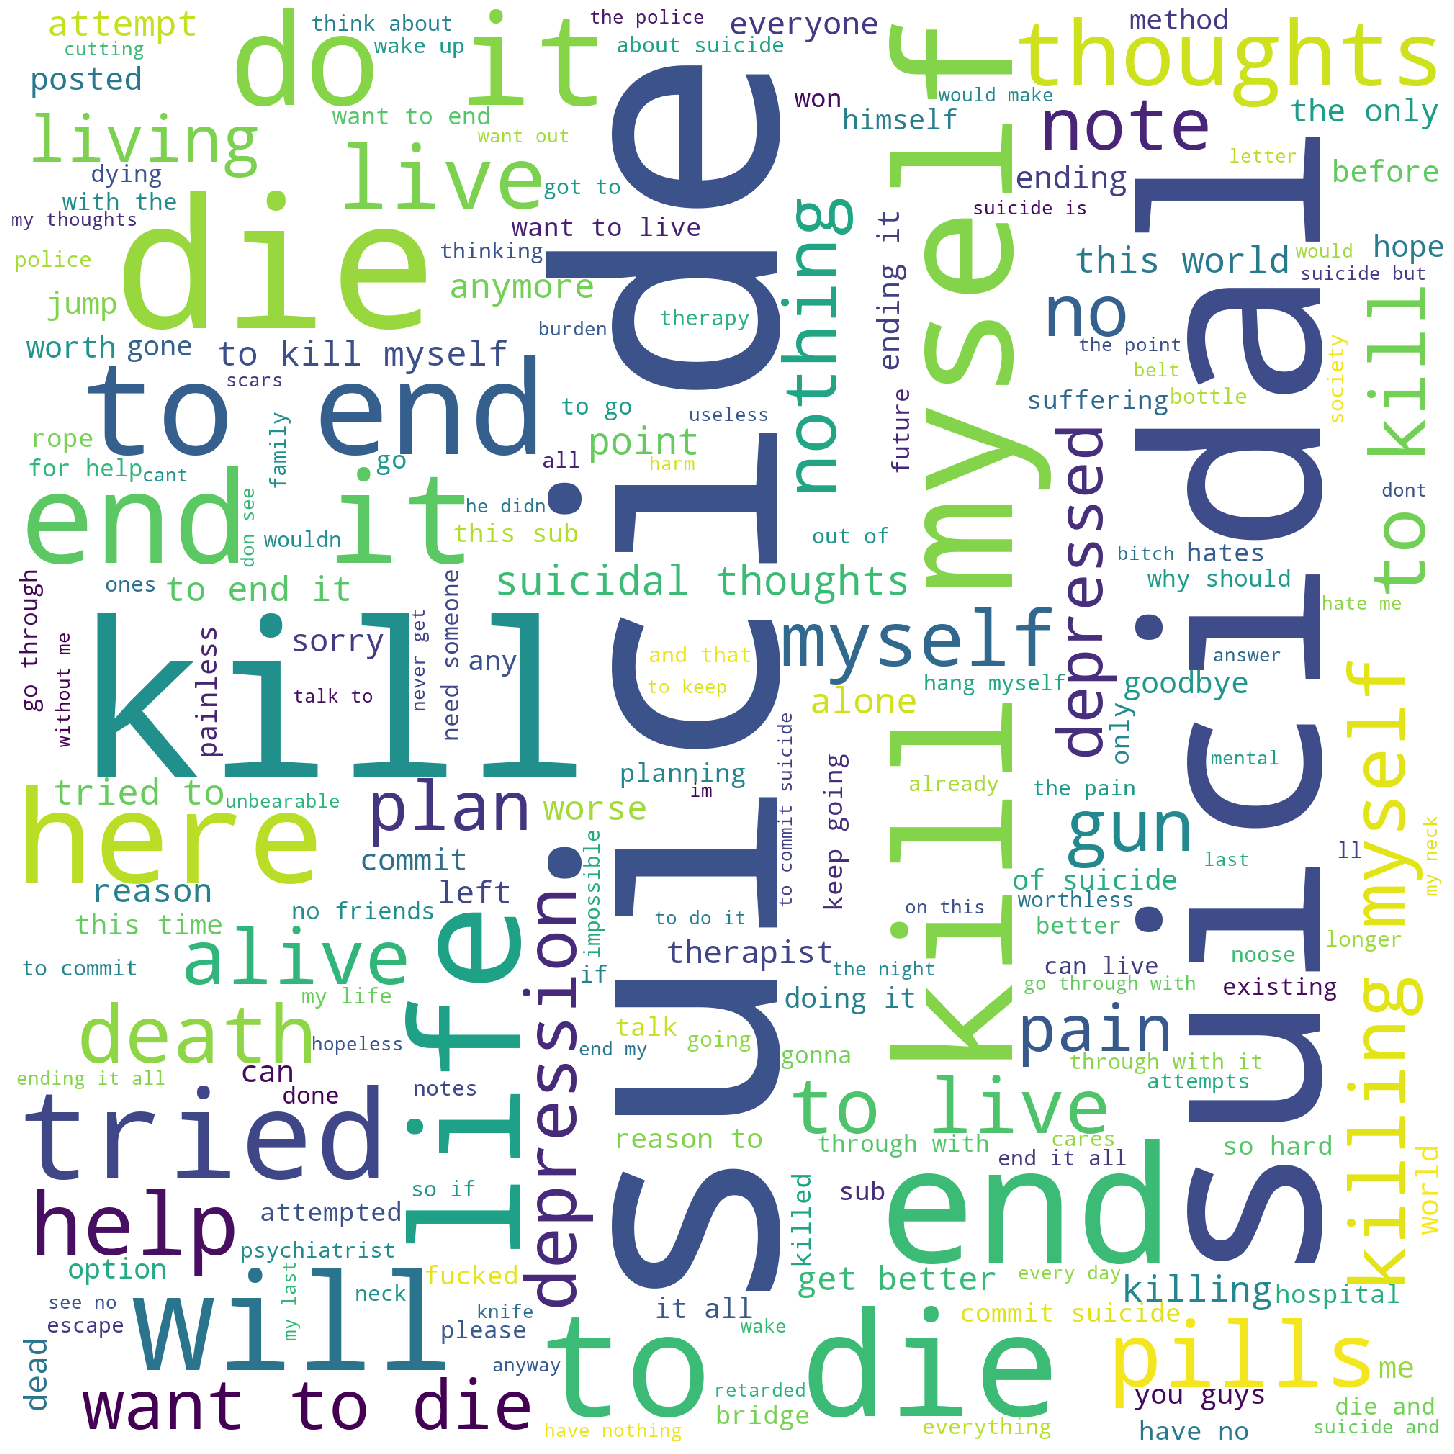

In [118]:
d={}
for key, val in SWWordCloud.values:
    d[key] = int(val**2)
    
wordcloud = WordCloud(width = 2000, height = 2000, 
                background_color ='white',  
                min_font_size = 10).generate_from_frequencies(d)

plt.figure(figsize = (20, 20), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [119]:
#Puts predicted probabilities and associated text into a dataframe
predictions = pd.DataFrame(gs_lr2.predict_proba(X))
predictions['text'] = posts['selftext']

In [120]:
predictions.sort_values(1)[0:25]

,0,1,text
5383,0.999997,0.000003,I want to kill myself.
5459,0.999989,0.000011,I want to die.
1826,0.999938,0.000062,I WANT TO FUCKING KILL MYSELF I DON’T WANT TO ...
4871,0.999927,0.000073,I just want to die
816,0.999900,0.000100,I hate myself and i hate my life. I can't slee...
6845,0.999850,0.000150,I really want to end it...............and i de...
3257,0.999817,0.000183,i’ve tried to kill myself before and i thought...
1548,0.999667,0.000333,I want to die. Please. Just fuckin kill me. I ...
36,0.999659,0.000341,"I have been listening to podcasts, reading art..."
1338,0.999650,0.000350,"i dont want to kill myself, i just really want..."


In [123]:
def print_comment_if_string(string,post):
    if string.lower() in post.lower():
        print(post)
        print('-----')

In [124]:
#Just change the string and run the loop to search for comments
for i in posts['selftext']:
    print_comment_if_string('i can',i)

Serious question. I was born catholic, but few years ago had this realization when I was meddling with philosophy that there is no God. Now, for me that meant that life stopped having a meaning. What’s the point? Am I going to be used by government until I’m old? So I decided that instead of killing myself, I would go full hedonist and indulge in all the pleasures that life can offer... but I can’t really afford that. The closest thing to hedonistic pleasures was good food and alcohol. But I stopped enjoying eating, I still do overeat but only as a coping mechanism. In my opinion, the biggest pleasure life has to offer is sex, and that I cannot get no matter what I do. Hookers in my location are so low quality that I would just catch some disease. But I can’t get a girlfriend either, that’s the dilemma. So am I supposed to kill myself? Let’s be honest, there is nothing better to do anyways. What will I do? Read a book? Get some stupid senseless hobby like most of you recommend? Tell me

So, recently my life has spiraled down a hole. I lost my job due to downsizing and this news was broken to me via webcam the day I returned to work from my short paternity leave. And without getting into specifics I have not been able to catch a break since, in fact quite the opposite. If the universe were a thing or entity capable of making choices I'd swear that it moved from supremely uninterested in me - to trying to see what it can throw at me to find out at what point I will just totally fucking break. I struggled with Depression while I was working but being unemployed with 2 kids trying to pay the bills and plug all the holes in what feels like a sinking ship - has just put enormous pressure on me and honestly. I am cracking. Today, I sat in my office and sobbed for the better part of an hour. I was alone with my thoughts. I just want this all this pain to stop. And to those of you who would say that it is up to me to make my situation change, I am attacking my unemployment iss

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [126]:
predictions = pd.DataFrame(gs_lr2.predict_proba(X))
predictions['text'] = posts['selftext']
predictions['true'] = posts['subreddit']
predictions['pred'] = gs_lr2.predict(X)
predictions.columns = ['SuicideWatch','OffMyChest','text','true','pred']
predictions = predictions[['text','true','pred','SuicideWatch','OffMyChest']]

In [127]:
#Let's look at comments where the model guessed wrong.
wrong = predictions[predictions['true']!=predictions['pred']]

In [128]:
#Predicts SW strongly when the answer is OMC
wrong.sort_values('SuicideWatch',ascending=False).head(10)

,text,true,pred,SuicideWatch,OffMyChest
12372,People constantly go on and fucking on about h...,offmychest,SuicideWatch,0.994212,0.005788
10239,I’ve spent half my life wanting to end it. I n...,offmychest,SuicideWatch,0.989522,0.010478
7499,"Seriously, what’s the point? I can’t seem to f...",offmychest,SuicideWatch,0.987887,0.012113
9995,Anymore Anymore Anymore Anymore Anymore Anymor...,offmychest,SuicideWatch,0.987056,0.012944
12041,"Like ever other night, I’m fucking trashed and...",offmychest,SuicideWatch,0.985649,0.014351
7459,I had the noose around my neck and was startin...,offmychest,SuicideWatch,0.984057,0.015943
12383,This is just another venting post by just anot...,offmychest,SuicideWatch,0.983463,0.016537
8832,"Warning: suicidal Everyday it just gets worse,...",offmychest,SuicideWatch,0.978312,0.021688
10431,Now every time I see ambulances or police I pa...,offmychest,SuicideWatch,0.973587,0.026413
9767,I think my life would be unrecognizably better...,offmychest,SuicideWatch,0.966301,0.033699


In [129]:
#Predicts AskWomen strongly when the answer is AskMen
wrong.sort_values('OffMyChest',ascending=False)[31:40]

,text,true,pred,SuicideWatch,OffMyChest
6903,"Hi, someone told me this subreddit exists, so ...",SuicideWatch,offmychest,0.094057,0.905943
6721,I've not had a hard life and I'm in one of the...,SuicideWatch,offmychest,0.104718,0.895282
3107,I've been suffering with anxiety and depressio...,SuicideWatch,offmychest,0.107725,0.892275
6832,the thing is my mom wants me to get 90 as an a...,SuicideWatch,offmychest,0.108689,0.891311
4799,Life... Life is never easy neither fair or is ...,SuicideWatch,offmychest,0.110775,0.889225
1290,I was making pasta for my family when I decide...,SuicideWatch,offmychest,0.113061,0.886939
4479,I know that you are in pain and this looks lik...,SuicideWatch,offmychest,0.115206,0.884794
3074,That he always believed in me... That i've nev...,SuicideWatch,offmychest,0.116407,0.883593
3015,I haven't had a really suicidal mindset in alm...,SuicideWatch,offmychest,0.116448,0.883552


In [125]:
from nltk.tokenize import RegexpTokenizer
coefs = pd.read_csv('data/coef_ranks.csv')

#Copy comment string in here, insert \ before apostrophes
comment = 'You need to be able to distinguish between a girl that likes the attention youre giving her from a girl that likes you. Most girls at a party will smile and talk to you if you approach them with confidence. After you talk to her though, you need to find a way for her to invest in the interaction. If she never invests in it you never really know what she wants. Walking away from the girl without getting any info is a good way to do this. You started the first conversation, now shes on the spot. If she doesnt come up to you and talk to you again, she isnt getting your number. This forces her to be more than just a receiver of attention. If youre leaving the party, or think you might not see her again at that party. Give her your contact info, dont take any of hers. Shes then forced to reach out to you if she wants things to go anywhere. Not only will this tell you if shes actually interested in you, it will make her more attracted. She will see that you arent desperate, and that makes you more attractive. Girls can sense when the only reason youre talking to them is to get their number or something like that. They can see right through you. When you walk away without the number, she realizes youre not just trying to get her number, you actually just wanted to talk to her. That is attractive'

#Converts comment to list of lowercase tokens
tokenizer = RegexpTokenizer(r'\w+')
comment_tokens = tokenizer.tokenize(comment.lower())

#Creates dataframe with words from comment, in order, with their coefficients
coef_list = []
for i in range(len(comment_tokens)):
    gram = comment_tokens[i]
    try:
        coef = coefs[coefs['ngram']==gram]['coef'].values[0]
    except:
        coef = np.nan
    coef_list.append(coef)   

d = {'gram':comment_tokens,'coef':coef_list}

df = pd.DataFrame(d).fillna(0)
df.to_csv('data/tableau_data.csv')

## Conclusion and Recommendations 